### Info electrodes, rois, labels, AUC SCORE
#### From the beginning - electrodes included in the analysis
    Create the big file data 'all_subjects_info_elecs.csv'

In [12]:
from brainpipe.system import study
from os.path import isfile, join
import numpy as np
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

conds = ['early','late']#['low','high']
meth, exps = 'BETWEEN',['E'] #'E' within separatetly because no CHAF 
skfs = ['5']
met = 'zFisher' #k=10
###############################################################################
st = study('Olfacto')
path_npz = join(st.path, 'classified/TPSim_clf_EarlyLate_theta_last_analyses/')
f_form = join(path_npz, '{}_LDA_clf_'+meth+'_{}_'+conds[0]+'_'+conds[1]+'_{}_k={}.npz')
dfname = '0_all_subjects_info_elecs_new.csv'
df_all_name = '1_all_subjects_info_elecs_AUC_Pow_Time_{}_{}_k={}.csv'
###############################################################################

freqs = ['theta']
#put here if selection change but all ROIs already selected when creating npz
#before permutation threshold calculations
rois_to_keep = ['ACC','aHC','IFG','Ins_olf','MFG','OFC_olf',
                'PHG','SFG','pPirT','Amg','Amg-PirT']

mat = np.load(f_form.format('All_subjects',exps[0],freqs[0],skfs[0]))
print(mat.files)
idx_rois = np.where([ roi in rois_to_keep for roi in mat['s_labels']])

subjects = mat['su_codes'][idx_rois][:,np.newaxis]
elecs = mat['s_elec'][idx_rois][:,np.newaxis]
s_Mai_RL = mat['s_labels'][idx_rois][:,np.newaxis]
channels = mat['s_channels'][idx_rois][:,np.newaxis]
x = mat['s_xyz'][:,0][idx_rois][:,np.newaxis]
y = mat['s_xyz'][:,1][idx_rois][:,np.newaxis]
z = mat['s_xyz'][:,2][idx_rois][:,np.newaxis]
#s_channels = mat['s_channels'][idx_rois][:,np.newaxis]
print(subjects.shape, s_Mai_RL.shape)
elec_data = np.concatenate((subjects, s_Mai_RL,channels,x,y,z,elecs), axis=1)
df0 = pd.DataFrame(elec_data, columns=['subjects','s_Mai_RL','channels','x','y','z','elecs_num'])
df0.to_csv(path_npz+dfname)
print(df0.shape)

for exp, skf in product(exps,skfs):
    # load all electrodes information and create a df
    idx_all, pow0_all, pow1_all, da_all = np.array([]),np.array([]),np.array([]),np.array([])
    for freq in freqs:
        mat = np.load(f_form.format('All_subjects',exp,freq,skf))
        nelecs = mat['s_elec_pow0'].shape[0]
        print(nelecs)
        idx_elecs, pow0_elecs, pow1_elecs, da_elecs = np.array([]),np.array([]),np.array([]),np.array([])
        for elec in range(nelecs):
            da = mat['s_da'][elec]
            if np.size(da) > 1:
                idx_elec = [i for i,j in enumerate(da) if j == max(da)][0]
                da_elec = max(da)
                print(idx_elec, da_elec, mat['s_elec_pow0'][elec].shape)
                pow0_elec = np.mean(mat['s_elec_pow0'][elec][idx_elec])
                pow1_elec = np.mean(mat['s_elec_pow1'][elec][idx_elec])
            else:
                da_elec = da
                pow0_elec = mat['s_elec_pow0'][elec]
                pow1_elec = mat['s_elec_pow1'][elec]
            pow0_elecs = np.hstack((pow0_elecs,pow0_elec)) if np.size(pow0_elecs) else pow0_elec
            pow1_elecs = np.hstack((pow1_elecs, pow1_elec)) if np.size(pow1_elecs) else pow1_elec
            #idx_elecs = np.hstack((idx_elecs, idx_elec)) if np.size(idx_elecs) else idx_elec
            da_elecs = np.hstack((da_elecs,da_elec)) if np.size(da_elecs) else da_elec
        #idx_all = np.vstack((idx_all, idx_elecs)) if np.size(idx_all) else idx_elecs
        pow0_all= np.vstack((pow0_all, pow0_elecs)) if np.size(pow0_all) else pow0_elecs
        pow1_all= np.vstack((pow1_all, pow1_elecs)) if np.size(pow1_all) else pow1_elecs
        da_all = np.vstack((da_all, da_elecs)) if np.size(da_all) else da_elecs
    df2 = pd.DataFrame(da_all.T, columns=[freq+'_AUC' for freq in freqs])
    df3 = pd.DataFrame(pow0_all.T, columns=[freq+'_Pow0' for freq in freqs])
    df4 = pd.DataFrame(pow1_all.T, columns=[freq+'_Pow1' for freq in freqs])
    #df5 = pd.DataFrame(idx_all.T, columns=[freq+'_Time' for freq in freqs])
    df_all = pd.concat((df0,df2,df3,df4),axis=1)
    #df_all = df.join(df2, how='left')
    df_all.to_csv(path_npz+df_all_name.format(exp,meth,skf))
    print(df_all.shape)


-> Olfacto loaded
['su_codes', 's_xyz', 's_labels', 's_elec_pow0', 's_elec_pow1', 's_da', 's_perm', 's_elec', 's_channels']
(230, 1) (230, 1)
(230, 7)
230
(230, 10)


#### Plot nb of signif electrodes by subjects and freq - TOTAL

In [2]:
from brainpipe.system import study
from os import makedirs
from os.path import isfile, join, exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib notebook
from itertools import product

In [14]:
conds = ['early','late']#['low','high']
meth, exps = 'BETWEEN',['E']
skfs, rad = ['5'], 11
thrs = ['0.05','0.01','0.001']
freqs = ['theta']
###############################################################################
st = study('Olfacto')
path_npz = join(st.path, 'classified/TPSim_clf_EarlyLate_theta_last_analyses/')
path_mask = join(path_npz, 'masks_stat/')
f_form = join(path_mask, 'All_subjects_mask_stat_'+meth+'_{}_{}_th{}_not_corr_freqs_k={}.npy')
filename = '1_all_subjects_info_elecs_AUC_Pow_Time_{}_{}_k={}.csv'
df_name = '2_all_subjects_signif_rad='+str(rad)+'_{}_{}_p={}_k={}_not_corr_freqs.csv'
###############################################################################

for th, exp, skf in product(thrs,exps,skfs):
    all_mask = np.array([])
    for freq in freqs:
        mask = np.load(f_form.format(exp,freq,th,skf))[:,np.newaxis]
        all_mask = np.concatenate((all_mask,mask), axis=1) if all_mask.size else mask
    #create a DataFrame with all stats for all freqs
    df = pd.DataFrame(all_mask, columns=['sig_1lev'+f for f in freqs]) #boolean df
    # Tranform True value by 0 and False value by 1
    df = df*-1+1

    # Load elecs file information
    df2 = pd.read_csv(path_npz+filename.format(exp,meth,skf), sep=',')
    df2 = pd.concat([df2,df], axis=1)
    df2.drop(['Unnamed: 0'],inplace=True, axis=1)
    df2.set_index(['subjects'], inplace=True)

    # Add information about the lobe of elecs
    dict_regions ={ 'ACC':'Frontal','IFG':'Frontal','MFG':'Frontal','SFG':'Frontal',
                    'Amg':'Olf','pPirT':'Olf','Amg-PirT':'Olf','Ins':'Olf','OFC_olf':'Olf',
                    'aHC':'MTL','pHC':'MTL','PHG':'MTL','FuG':'Temporal','ITG':'Temporal',
                    'MTG':'Temporal','STG':'Temporal','OFC':'Olf'}
    df2['region'] = df2['s_Mai_RL'].map(dict_regions)
    df2.to_csv(path_npz+df_name.format(exp,meth,th,skf))                

-> Olfacto loaded


### Plot wiht one level

<IPython.core.display.Javascript object>


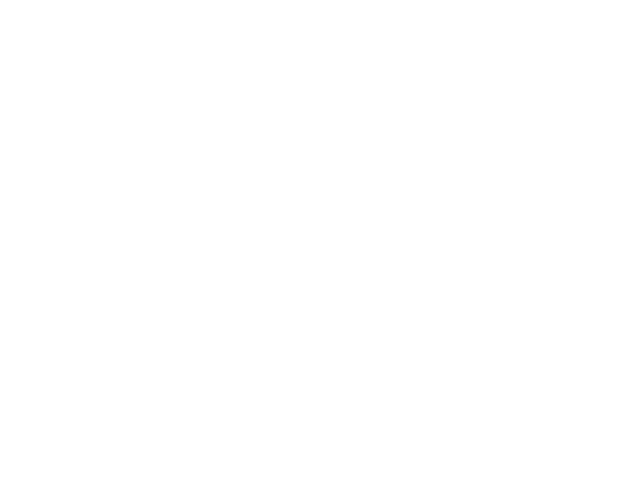

ValueError: The lengths of the data (5) and the error 1 do not match

In [7]:
#df2 = df2.loc[df2['s_Mai_RL']!='OFC']
freqnames, min_wins = freq, [1]
#Plot nb of significant electrodes by win
fig = plt.figure()
plt.title('Significant electrodes by frequency band')
plt.ylabel('Nb of electrodes')
xticks, w = np.arange(0,len(freqnames)*len(min_wins),len(min_wins)), 0.8
plt.xticks(xticks,freqnames)

sig = '1_lev'
df3 = df2.filter(like='sig').agg(('sum','std','sem'))
plt.bar(xticks,df3.loc[['sum']].values[0],color='gold',
        yerr=df3.loc[['std']].values[0], label='win1')
print('total elecs count',df3.loc[['sum']])
plt.legend(loc=0,handletextpad=0.1, frameon=False)
if corr == True:
    plt.savefig(path2save+'Total_elec_signif_freq_4500_th_'+th+'_corr.png')
else:
    plt.savefig(path2save+'Total_elec_signif_freq_4500_th_'+th+'_'+max_stat+'.png')
plt.clf()
plt.close()

#Plot nb of significant electrodes by win and subjects
colors = {'CHAF':'darkblue', 'FERJ':'royalblue', 'LEFC':'deepskyblue', 
        'PIRJ':'yellow','SEMC':'darkorange', 'VACJ':'red'}
df4 = df2.groupby(['subjects']).agg(('sum','std')).filter(like='sig')
xticks, w = np.arange(0,len(freqnames)*len(min_wins),len(min_wins)), 0.8
fig = plt.figure()
bottom = np.zeros(len(freqnames))
for i,su in enumerate(df4.index):
    count = df4.iloc[[i]].filter(like='sum').values[0]
    print(count)
    xpts = range(len(count))
    print('shape to plot',count.shape, xticks.shape)
    plt.bar(xpts, count, color=colors[su], label=su, bottom=bottom)
    bottom += count
plt.title('Significant electrodes by frequency band for all subjects')
plt.ylabel('Nb of electrodes')
plt.xticks(xticks,freqnames)
#plt.ylim(0,55)
plt.legend(loc=0,handletextpad=0.1, frameon=False)
print(path2save)
plt.savefig(path2save+'Total_patients_elec_signif_freq_4500_th_'+th+'_'+sig+'_mean_'+max_stat+'.pdf')
plt.savefig(path2save+'Total_patients_elec_signif_freq_4500_th_'+th+'_'+sig+'_mean_'+max_stat+'.png')
plt.clf()
plt.close()

### plot perf with  or 2 levels

<IPython.core.display.Javascript object>


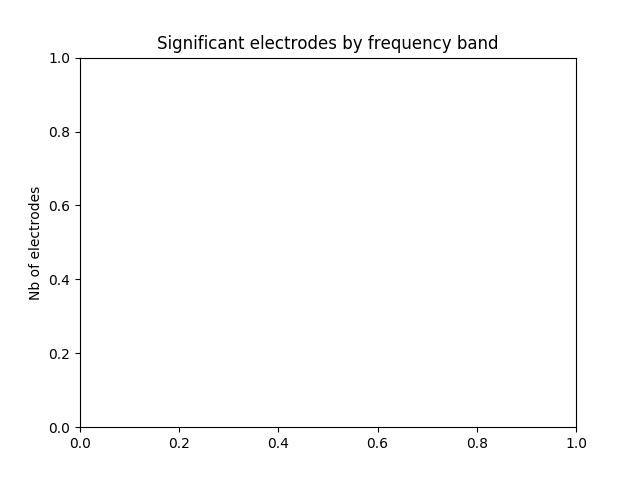

NameError: name 'freqnames' is not defined

In [5]:
#Plot nb of significant electrodes by win
fig = plt.figure()
plt.title('Significant electrodes by frequency band')
plt.ylabel('Nb of electrodes')
xticks, w = np.arange(0,len(freqnames)*len(min_wins),len(min_wins)), 0.8
plt.xticks(xticks,freqnames)

sig = '2lev_sig' #2lev_sig, sig_1lev
df2 = df_perf.filter(like=sig).agg(('sum','std','sem'))
plt.bar(xticks,df2.loc[['sum']].values[0],color='gold',
        yerr=df2.loc[['std']].values[0], label='win1')
print('total elecs count',df2.loc[['sum']])
plt.legend(loc=0,handletextpad=0.1, frameon=False)
if corr == True:
    plt.savefig(path2save+'Total_elec_signif_freq_4500_th_'+th+'_corr.png')
else:
    plt.savefig(path2save+'Total_elec_signif_freq_4500_th_'+th+'_'+sig+'.png')
plt.clf()
plt.close()

#Plot nb of significant electrodes by win and subjects
colors = {'CHAF':'darkblue', 'FERJ':'royalblue', 'LEFC':'deepskyblue', 
        'PIRJ':'yellow','SEMC':'darkorange', 'VACJ':'red'}
df4 = df_perf.groupby(['subjects']).agg(('sum','std')).filter(like=sig)
xticks, w = np.arange(0,len(freqnames)*len(min_wins),len(min_wins)), 0.8
fig = plt.figure()
bottom = np.zeros(len(freqnames))
for i,su in enumerate(df4.index):
    count = df4.iloc[[i]].filter(like='sum').values[0]
    print(count)
    xpts = range(len(count))
    print('shape to plot',count.shape, xticks.shape)
    plt.bar(xpts, count, color=colors[su], label=su, bottom=bottom)
    bottom += count
plt.title('Significant electrodes by frequency band for all subjects')
plt.ylabel('Nb of electrodes')
plt.xticks(xticks,freqnames)
plt.ylim(0,25)
plt.legend(loc=0,handletextpad=0.1, frameon=False)
plt.savefig(path2save+'Total_patients_elec_signif_freq_4500_th_'+th+'_'+sig+'v2.pdf')
plt.savefig(path2save+'Total_patients_elec_signif_freq_4500_th_'+th+'_'+sig+'v2.png')
plt.clf()
plt.close()

#### Plot signif electrodes by frequency bands, subjects and ROIs

In [40]:
from brainpipe.system import study
from os import makedirs
from os.path import isfile, join, exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from itertools import product

conds,th, corr = ['low','high'],'0.01', False
method, exp = 'region', 'E'
min_wins, min_sigs, rad = ['1'],[1], '11'#[1,2,3,4,5]
max_stat = 'corr_all'
###############################################################################
st = study('Olfacto')
path = join(st.path, 'figure/TPSim_LDA_'+exp+'_by_cond_6freqs_3s_dissim/')
path2save = path+'/Signif_elecs'+th+'/'
#freqs = ['2_theta', '3_alpha', '4_beta','5_gamma1','6_gamma2']
freqs = ['delta', 'theta','alpha','beta','low_gamma','high_gamma']
freqnames = freqs#[freq[2:] for freq in freqs]
minwin_names = ['min_win'+str(min_win[:]) for min_win in min_wins]
filename = '2_all_subjects_info_elecs_AUC_Signif_th_'+th+'_mean_'+max_stat+'_'+str(rad)+'_not_corr.csv'
###############################################################################
if not exists(path2save):
    makedirs(path2save)
###############################################################################

df = pd.read_csv(path+filename, sep=',')
df = df.loc[df['s_Mai_RL']!='OFC']
df = df.set_index(['subjects',method])
df2 = df.groupby(['subjects',method]).sum().unstack()
df2 = df2.fillna(0)
#df2 = df2.swaplevel(0,1,axis =1)
colors = {'CHAF':'darkblue', 'FERJ':'royalblue', 'LEFC':'deepskyblue', 
        'PIRJ':'yellow','SEMC':'darkorange', 'VACJ':'red'}

for freq in freqnames:
    df3 = df2.filter(like=freq)
    for i in range(len(df3.columns.levels[0])):
        col = df_sel.iloc[:,[i]]
        if df_sel.iloc[:,[i]].values.astype(bool).sum() < min_sig:
            df3 = df3.drop(col,axis=1)
        else:
            continue
        print('freq', freq, 'min_win',min_win, 'rois signif',df3.shape[1],'nb elecs by rois',df3.sum())
        print('total electrodes',sum(df3.sum(axis=1)))
        if df3.shape[1]>0:
            names = np.array(df3.columns.get_level_values(0).values)
            print(names)
            #np.save((path2save+'s_Mai_RL'+'_signif_min_'+str(min_sig) \
            #         +'_'+freq+'_min_win'+min_win+'_th_'+th+'_'+max_stat+'.npy'),names)
            bottom = np.zeros(len(df3.columns))
            for s in df3.index:
                count = df3.iloc[df3.index == s].values[0]
                xpts = range(len(count))
                plt.bar(xpts, count, bottom=bottom, color=colors[s], label=s, width=0.8)
                bottom += count
            plt.title('Significant electrodes by ROI/Subject for '+freq+' min_win'+min_win+' th '+th)
            plt.ylabel('Nb of electrodes')
            plt.xticks(xpts,list(df3.columns.get_level_values(0)),rotation=90)
            plt.tight_layout()
            plt.ylim(bottom=0, top=20)
            plt.xlim(xmin=-1,xmax=11)
            plt.legend(loc='best')
            plt.savefig(path2save+'Nb_elecs_signif_min_'+str(min_sig)+'_'+freq+'_min_win'+min_win+'_th_'+th+'_'+method+'.png')
            plt.savefig(path2save+'Nb_elecs_signif_min_'+str(min_sig)+'_'+freq+'_min_win'+min_win+'_th_'+th+'_'+method+'.pdf')
            plt.clf()
            plt.close()

-> Olfacto loaded
          delta_AUC                      delta_Pow0                        \
region      Frontal        MTL       Olf    Frontal        MTL        Olf   
subjects                                                                    
CHAF      35.013636   0.000000  0.000000  42.437523   0.000000   0.000000   
FERJ       1.547131  12.369554  6.956239   2.468085  22.584362  11.362180   
LEFC       8.546176   4.345954  5.032239  16.015747   7.133166   9.588333   
PIRJ       0.648148   8.832037  3.582963   1.947121  17.212590   6.060238   
SEMC      22.252424   2.274360  3.717811  38.169128   4.743023   5.441940   
VACJ      12.057167   4.139611  5.858833  17.212717   6.571018   8.299363   

         delta_Pow1                      sig_1levdelta            
region      Frontal        MTL       Olf       Frontal  MTL  Olf  
subjects                                                          
CHAF      53.157392   0.000000  0.000000          13.0  0.0  0.0  
FERJ       2.579066 

IndexError: positional indexers are out-of-bounds

-> Olfacto loaded
Index(['subjects', 's_Mai_RL', 'channels', 'x', 'y', 'z', 'elecs_num',
       'raw_AUC', 'raw_Pow0', 'raw_Pow1', 'sig_1levraw'],
      dtype='object')
    subjects s_Mai_RL   channels      x      y      z  elecs_num   raw_AUC  \
164     PIRJ      IFG    o12-o11  48.10  39.20 -13.15         26  0.622569   
176     SEMC      IFG      e7-e6  53.65  19.75  13.70          8  0.701701   
257     VACJ      IFG  k'12-k'11 -43.35  33.05   9.50         27  0.661532   

     raw_Pow0  raw_Pow1  sig_1levraw  sign  
164  0.079895  0.010255            1  -1.0  
176  0.054332 -0.027090            1  -1.0  
257  0.113066  0.010367            1  -1.0  


<IPython.core.display.Javascript object>


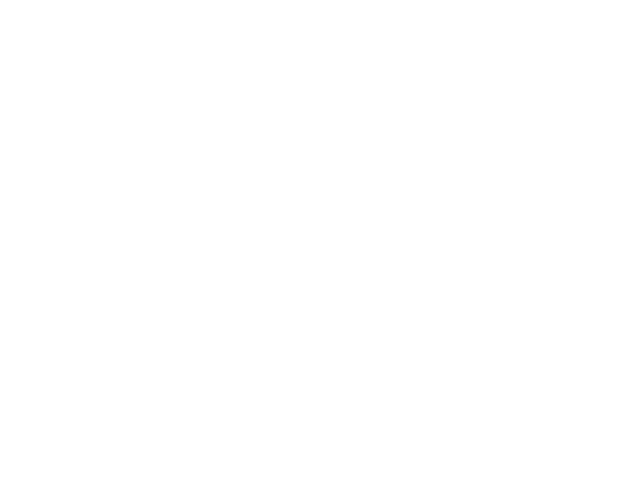

<IPython.core.display.Javascript object>


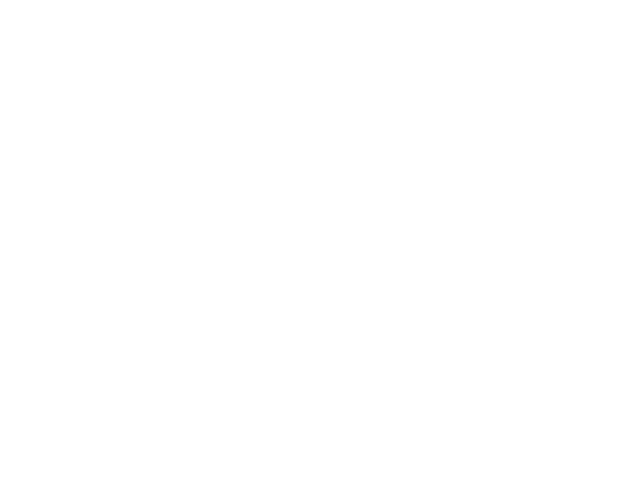

<IPython.core.display.Javascript object>


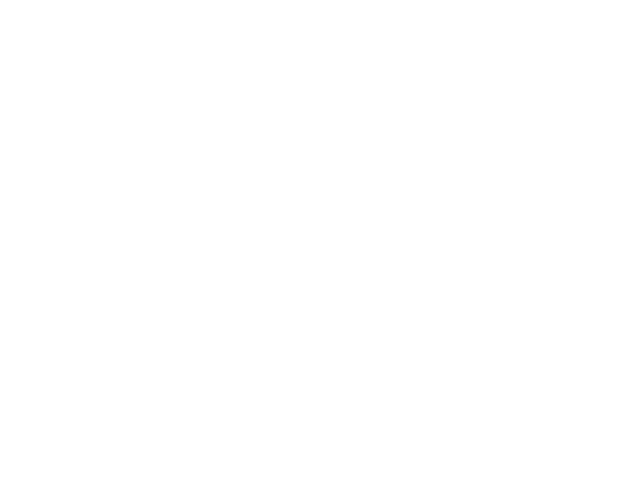

           raw_AUC
s_Mai_RL       IFG
subjects          
PIRJ      0.622569
SEMC      0.701701
VACJ      0.661532


<IPython.core.display.Javascript object>


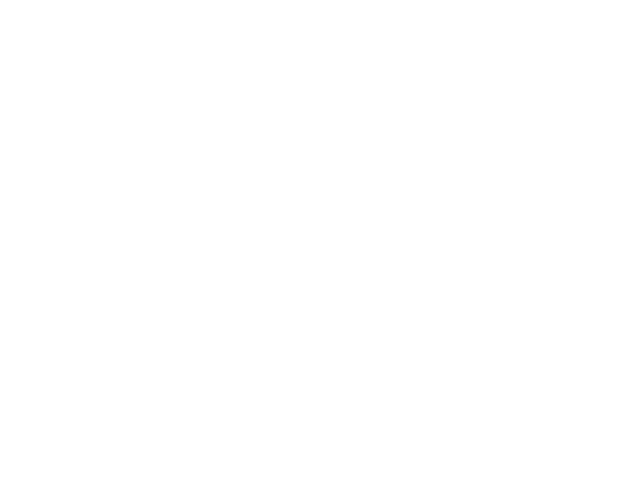

In [30]:
from brainpipe.system import study
from os.path import join, exists
from os import makedirs
import numpy as np
from itertools import product
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import sem

st = study('Olfacto')
exp, th, met = 'R', '0.01', 'zFisher'
pathdata = join(st.path, 'figure/TPSim_LDA_'+exp+'_by_cond_raw_3s/')
path2save = join(pathdata, 'Signif_elecs'+th+'/')

leg = ['Low', 'High']
#freqs = ['theta','alpha','beta','BBG']
freqs = ['raw']
dfname = '2_all_subjects_info_elecs_AUC_Signif_th_'+th+'_11_k=5.csv'

df_sel = pd.read_csv(pathdata+dfname)
df_ = df_sel[['subjects','s_Mai_RL','channels','x','y','z','elecs_num']]

#Select results significant for each frequency band and ROIs
for freq in freqs:
    df_freq = pd.concat([df_,df_sel.filter(like=freq[:])], axis=1)
    print(df_freq.columns)
    df_sig = df_freq.loc[df_freq['sig_1lev'+freq[:]]>0]
    sig_rois = np.unique(df_sig['s_Mai_RL'])
    list_df_rois =[]
    for roi in sig_rois:
        df_roi_f = df_sig.loc[df_sig['s_Mai_RL'] == roi]
        nb_su = len(np.unique(df_roi_f['subjects']))
        if (nb_su >= 3 and roi != 'OFC') or (nb_su >=2 and roi in ['pPirT','OFC_olf']):
            auc = df_roi_f[freq+'_AUC'].values
            auc_mean, std_auc = np.mean(auc), np.std(auc)
            
            #create a value of 1 for increase, -1 for decrease and 0 for no change
            df_roi_f['sign'] = np.sign(df_freq[freq+'_Pow1'] - df_freq[freq+'_Pow0'])
            inc = (df_roi_f.loc[df_roi_f.sign == 1.0]).shape[0]
            dec = (df_roi_f.loc[df_roi_f.sign == -1.0]).shape[0]
            
            df_inc = df_roi_f.loc[df_roi_f.sign == 1.0].groupby(['subjects']).count()
            df_dec = df_roi_f.loc[df_roi_f.sign == -1.0].groupby(['subjects']).count()
            
            if (df_inc.shape[0] >= 3) or (df_inc.shape[0] >=2 and roi in ['pPirT','OFC_olf']):
                df_plot = df_roi_f.loc[df_roi_f.sign == 1.0]
                list_df_rois.append(df_plot)
                print(df_plot)
                
            if (df_dec.shape[0] >= 3) or (df_dec.shape[0] >=2 and roi in ['pPirT','OFC_olf']):
                df_plot = df_roi_f.loc[df_roi_f.sign == -1.0]
                list_df_rois.append(df_plot)
                print(df_plot)
    
    if len(list_df_rois)>0:            
        df_rois = pd.concat(list_df_rois)

        #Plot nb of significant electrodes by win
        fig = plt.figure()
        plt.title('Significant electrodes for '+freq)
        plt.ylabel('Nb of electrodes')
        xticks, w = np.arange(0,2,1), 0.5
        plt.xticks(xticks,freq)

        df_plot = df_rois[['subjects','sig_1lev'+freq]].groupby('subjects').sum()
        sum_elecs = np.sum(df_plot['sig_1lev'+freq].values)
        sd_sum = np.std(df_plot['sig_1lev'+freq].values)
        plt.bar(xticks,sum_elecs,color='gold',yerr=sd_sum)
        plt.savefig(path2save+'Total_elec_signif_'+freq+'_th_'+th+'.png')
        plt.savefig(path2save+'Total_elec_signif_'+freq+'_th_'+th+'.pdf')
        plt.clf()
        plt.close()

        #Plot nb of significant electrodes by win and subjects
        colors = {'CHAF':'darkblue', 'FERJ':'royalblue', 'LEFC':'deepskyblue', 
                'PIRJ':'yellow','SEMC':'darkorange', 'VACJ':'red'}
        xticks, w = np.arange(0,1), 0.5
        fig = plt.figure()
        bottom = np.zeros(1)
        for i,su in enumerate(df_plot.index):
            count = df_plot.iloc[[i]].values[0]
            xpts = range(len(count))
            plt.bar(xpts, count, color=colors[su], label=su, bottom=bottom)
            bottom += count
        plt.title('Significant electrodes by frequency band for all subjects')
        plt.ylabel('Nb of electrodes')
        plt.xticks(xticks,freq)
        #plt.ylim(0,55)
        plt.legend(loc=0,handletextpad=0.1, frameon=False)
        plt.savefig(path2save+'Total_patients_elec_signif_'+freq+'th_'+th+'.pdf')
        plt.savefig(path2save+'Total_patients_elec_signif_'+freq+'th_'+th+'.png')
        plt.clf()
        plt.close()

        df_plot2 = df_rois[['subjects','s_Mai_RL','sig_1lev'+freq]].groupby(['subjects','s_Mai_RL']).sum()
        df_plot2 = df_plot2.unstack()
        rois = np.unique(df_rois['s_Mai_RL'].values)
        xticks, w = np.arange(0,len(rois)), 0.5
        fig = plt.figure()
        bottom = np.zeros(len(rois))
        for i,su in enumerate(df_plot2.index):
            count = df_plot2.iloc[i].values
            count = np.nan_to_num(count)
            xpts = range(len(count))
            plt.bar(xpts, count, bottom=bottom, color=colors[su], label=su, width=0.8)
            bottom += count
        plt.title('Significant electrodes by frequency band for all subjects')
        plt.ylabel('Nb of electrodes')
        plt.xticks(xticks,rois)
        plt.ylim(0,np.max(bottom)+1)
        plt.legend(loc=0,handletextpad=0.1, frameon=False)
        plt.savefig(path2save+'Total_patients_rois_signif_'+freq+'th_'+th+'.pdf')
        plt.savefig(path2save+'Total_patients_rois_signif_'+freq+'th_'+th+'.png')
        plt.clf()
        plt.close()

        df_plot2 = df_rois[['subjects','s_Mai_RL',freq+'_AUC']].groupby(['subjects','s_Mai_RL'])
        df_plot2 = df_plot2.mean().unstack()
        print(df_plot2)
        rois = np.unique(df_rois['s_Mai_RL'].values)
        xticks, w = np.arange(0,len(rois)), 0.8
        fig = plt.figure()
        means = df_plot2.mean()
        sd = df_plot2.sem()
        plt.bar(xpts, means, yerr=sd, color='orange', width=w)
        plt.title('Significant electrodes by frequency band for all subjects')
        plt.ylabel('Nb of electrodes')
        plt.xticks(xticks,rois)
        plt.ylim(0.45,0.9)
        plt.savefig(path2save+'AUC_patients_rois_signif_'+freq+'th_'+th+'.pdf')
        plt.savefig(path2save+'AUC_patients_rois_signif_'+freq+'th_'+th+'.png')
        plt.clf()
        plt.close()